In [1]:
import sys
# idk why but venv38 isn't on sys.path maybe we can fix this somehow whatever
sys.path = ['/cluster/home/bdayan/prox/venv38/lib64/python3.8/site-packages'] + sys.path


import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir('../')

from pose_gru import PoseGRU_inputFC2
from benji_prox_dataloader import *

numpy: 1.22.3


In [2]:
root_dir = '/cluster/scratch/bdayan/prox_data/PROXD_attempt2/PROXD'
smplx_model_path='../models_smplx_v1_1/models/'
in_frames = 10
pred_frames = 5
batch_size = 15
pd = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, output_type='raw_pkls', smplx_model_path=smplx_model_path)
pd2 = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, output_type='joint_locations', smplx_model_path=smplx_model_path)


dataloader = DataLoader(pd, batch_size=1,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

In [3]:
# specify device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


print('-- pytorch version={}'.format(torch.__version__))
print('-- device={}'.format(device))

smplx_model_path='../models_smplx_v1_1/models/'

import smplx  # SMPL-X; pip install smplx

def get_smplx_model(gender, device):
    body_model_path = smplx_model_path
    body_model = smplx.create(body_model_path, 
                          model_type='smplx',        ## smpl, smpl+h, or smplx?
                          gender=gender, ext='npz',  ## file format 
                          num_pca_comps=12,          ## MANO hand pose pca component
                          create_global_orient=True, 
                          create_body_pose=True,
                          create_betas=True,
                          create_left_hand_pose=True,
                          create_right_hand_pose=True,
                          create_expression=True, 
                          create_jaw_pose=True,
                          create_leye_pose=True,
                          create_reye_pose=True,
                          create_transl=True,
                          batch_size=1               ## how many bodies in a batch?
                          )
    body_model.eval()
    return body_model

smplx_neutral = get_smplx_model(gender='neutral', device=device)


def draw_bodies(gender, betas, thetas):
    bm = smplx_neutral


    ## read verts and face from smplx model
    params = {'betas': betas,
              'body_pose': thetas
              }


    verts = bm(return_verts=True, **params).vertices.detach().cpu().numpy()[0]
    faces = bm.faces

    ## put verts and face into open3d, and compute surface normal
    coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
    body = o3d.geometry.TriangleMesh()
    body.vertices = o3d.utility.Vector3dVector(verts)
    body.triangles = o3d.utility.Vector3iVector(faces)
    body.vertex_normals = o3d.utility.Vector3dVector([])
    body.triangle_normals = o3d.utility.Vector3dVector([])
    body.compute_vertex_normals()
    o3d.visualization.draw_geometries([body, coord])
    
    return None


-- pytorch version=1.10.0+cu102
-- device=cpu


In [5]:
_, in_data, out_data = pd.__getitem__(10)
outs = []
for data in in_data[1]:
    betas = torch.Tensor(data['betas'])
    body_pose = torch.Tensor(data['body_pose'])
    global_orient= torch.Tensor(data['global_orient'])
    transl=torch.Tensor(data['transl'])
    out = smplx_neutral(return_joints=True, betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)
    joints = out.joints[:, :25]
    outs.append(joints)

In [6]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [8]:
in_frame_dict = in_data[1][0]
in_frame_dict['global_orient']

array([[-2.7203133,  1.0107781, -2.0506995]], dtype=float32)

In [24]:
b.shape

torch.Size([10, 127, 3])

In [10]:

points = outs[0].squeeze()
rgb=torch.Tensor(np.random.random(points.shape)).to(device)
point_cloud = Pointclouds(points=[points], features=[rgb])

In [13]:
outs[0].shape

torch.Size([1, 25, 3])

(array([4., 4., 6., 1., 2., 1., 1., 1., 3., 2.]),
 array([-1.3010142 , -1.2414722 , -1.1819304 , -1.1223885 , -1.0628467 ,
        -1.0033047 , -0.94376284, -0.88422096, -0.824679  , -0.76513714,
        -0.70559525], dtype=float32),
 <BarContainer object of 10 artists>)

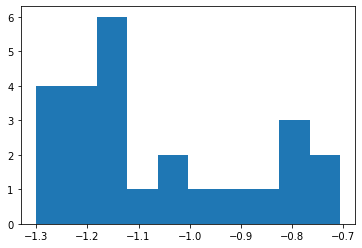

In [14]:
plt.hist(outs[0].squeeze()[:, 0].detach().numpy())

In [15]:

# Initialize a camera.
R, T = look_at_view_transform(5, 10, 0)
# R = in_frame_dict['camera_rotation']
# T = in_frame_dict['camera_translation']
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)
cameras = FoVPerspectiveCameras(device=device,R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.03,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor= NormWeightedCompositor(background_color=(1,0,0)) #AlphaCompositor(background_color=(0, 1., 0))
)

In [16]:
 look_at_view_transform(5, 10, 0)
R
T

(tensor([[[-1.0000,  0.0000,  0.0000],
          [ 0.0000,  0.9848, -0.1736],
          [-0.0000, -0.1736, -0.9848]]]),
 tensor([[-0., -0., 5.]]))

tensor([[[-1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.9848, -0.1736],
         [-0.0000, -0.1736, -0.9848]]])

tensor([[-0., -0., 5.]])

In [22]:
point_cloud.points_list()

[tensor([[-1.2137,  0.5942,  3.9336],
         [-1.1617,  0.6733,  4.0007],
         [-1.1796,  0.7023,  3.8790],
         [-1.3010,  0.5247,  3.9361],
         [-0.8040,  0.5738,  4.0151],
         [-0.8637,  0.6215,  3.7351],
         [-1.2666,  0.3975,  3.9058],
         [-0.8180,  0.9600,  3.9831],
         [-0.8101,  0.9979,  3.8291],
         [-1.2341,  0.3607,  3.8732],
         [-0.7133,  1.0370,  4.0090],
         [-0.7056,  1.0581,  3.7788],
         [-1.2456,  0.1949,  3.8310],
         [-1.2145,  0.2684,  3.8937],
         [-1.2520,  0.2843,  3.8162],
         [-1.1258,  0.0714,  3.8037],
         [-1.1341,  0.1942,  3.9500],
         [-1.2368,  0.2423,  3.7187],
         [-1.0427,  0.3928,  4.0852],
         [-1.1482,  0.4547,  3.5919],
         [-0.9036,  0.4725,  3.9113],
         [-0.9441,  0.5240,  3.5009],
         [-1.1358,  0.0687,  3.7931],
         [-1.0498,  0.0821,  3.7898],
         [-1.0765,  0.0851,  3.7355]], grad_fn=<SqueezeBackward0>)]

<Figure size 720x720 with 0 Axes>

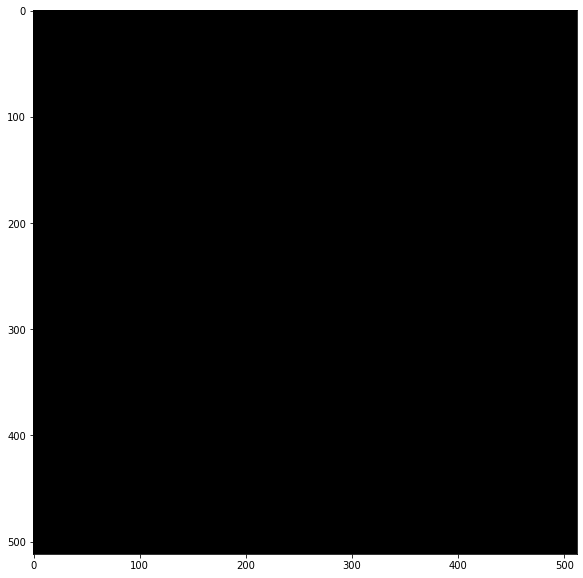

In [17]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().numpy())
# plt.axis("off");

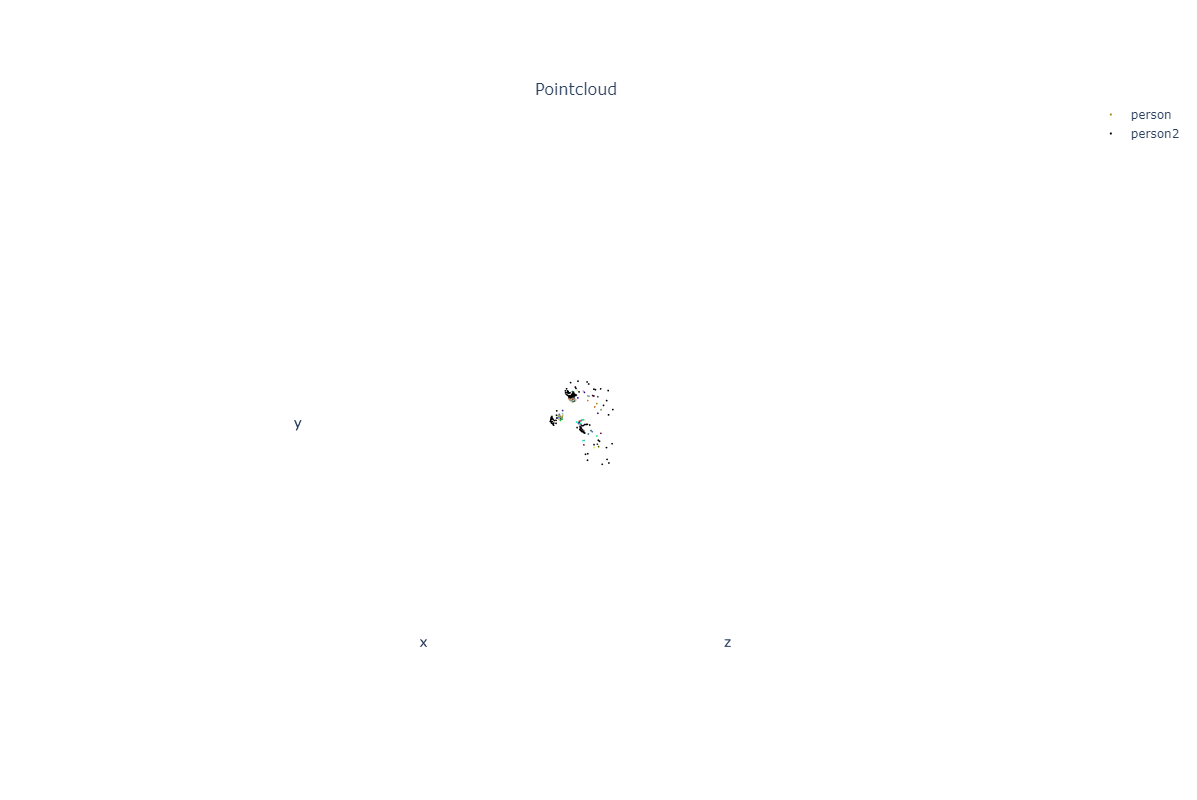

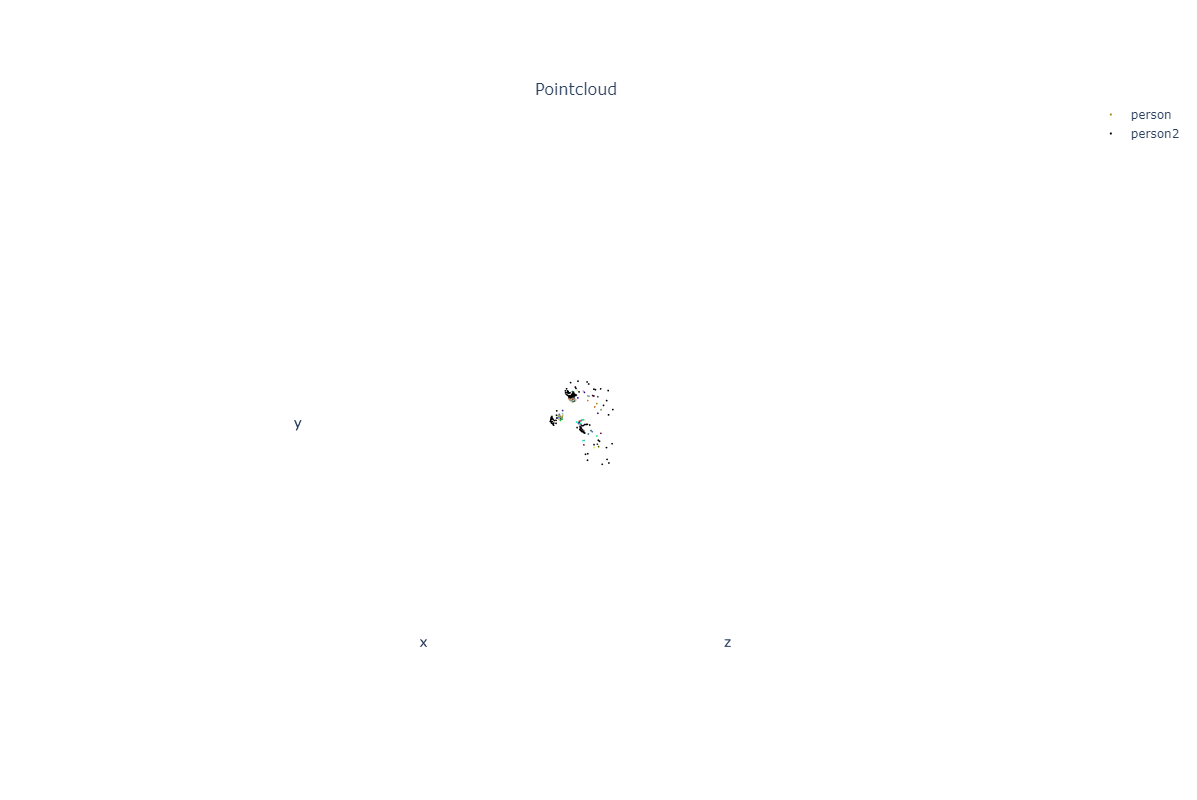

In [77]:
point_cloud_batch = Pointclouds(points=[points, points + 2], features=[rgb, torch.zeros_like(rgb)])
# render both in the same plot in different traces
fig = plot_scene({
    "Pointcloud": {
        "person": point_cloud_batch[0],
        "person2": point_cloud_batch[1]
    }
})
fig.update_layout(autosize=False,width=800,height=800)
fig.show()

In [42]:
R

tensor([[[-1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.9848, -0.1736],
         [-0.0000, -0.1736, -0.9848]]])

In [43]:
T

tensor([[-0., -0., 5.]])

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/cluster/scratch/bdayan/prox_data/recordings/N3OpenArea_00158_01/Color/s001_frame_00076__00.00.02.509.jpg')

In [40]:
img.shape

(1080, 1920, 3)

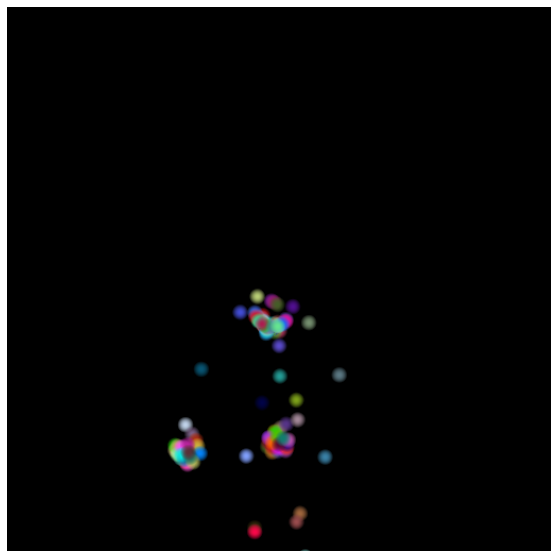

In [41]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().numpy())
plt.axis("off");

In [27]:
len(in_data[1])

10

In [28]:
g1 = in_data[1][0]['global_orient']
g2 = in_data[1][1]['global_orient']

In [58]:
g1
g2
from pytorch3d import transforms

array([[ 1.1642715, -0.5064939,  2.978201 ]], dtype=float32)

array([[ 1.242714 , -0.5080164,  2.951133 ]], dtype=float32)

In [67]:

# r1 = o3d.geometry.Geometry3D.get_rotation_matrix_from_xyz(g1.reshape(3, 1))
# r2 = o3d.geometry.Geometry3D.get_rotation_matrix_from_xyz(g2.reshape(3, 1))

r1 = transforms.euler_angles_to_matrix(torch.Tensor(g1), convention='XYZ')
r2 = transforms.euler_angles_to_matrix(torch.Tensor(g2), convention='XYZ')


In [72]:
g1

array([[ 1.1642715, -0.5064939,  2.978201 ]], dtype=float32)

In [69]:
r1.shape
r1.transpose(1, 2) @ r1

torch.Size([1, 3, 3])

tensor([[[1.0000e+00, 0.0000e+00, 2.8871e-08],
         [0.0000e+00, 1.0000e+00, 0.0000e+00],
         [2.8871e-08, 0.0000e+00, 1.0000e+00]]])

In [71]:
transforms.matrix_to_euler_angles(r2 @ r1.transpose(1, 2), convention='XYZ')

tensor([[ 0.0917,  0.0211, -0.0109]])

In [73]:
transforms.matrix_to_euler_angles(r1 @ r1.transpose(1, 2), convention='XYZ')

tensor([[-0.0000e+00, -1.4901e-08, -2.9802e-08]])

In [29]:
outs

[tensor([[[-0.4150,  0.2488,  2.5232],
          [-0.4491,  0.3484,  2.4745],
          [-0.3576,  0.3540,  2.5615],
          [-0.3891,  0.1443,  2.4939],
          [-0.5949,  0.6758,  2.5726],
          [-0.3504,  0.7028,  2.6339],
          [-0.4023,  0.0097,  2.4948],
          [-0.6543,  1.0304,  2.7177],
          [-0.3213,  1.0933,  2.6417],
          [-0.4136, -0.0404,  2.5236],
          [-0.7405,  1.0668,  2.8116],
          [-0.3948,  1.1626,  2.7245],
          [-0.3898, -0.2098,  2.5113],
          [-0.4429, -0.1261,  2.4899],
          [-0.3750, -0.1269,  2.5450],
          [-0.4740, -0.3604,  2.5355],
          [-0.5185, -0.1981,  2.4248],
          [-0.3228, -0.1933,  2.6111],
          [-0.4975,  0.0453,  2.3447],
          [-0.2574,  0.0575,  2.6541],
          [-0.5567,  0.2695,  2.3911],
          [-0.2741,  0.2773,  2.7326],
          [-0.4599, -0.3616,  2.5398],
          [-0.5337, -0.3930,  2.5738],
          [-0.4865, -0.3970,  2.6115]]], grad_fn=<SliceBackward0

In [39]:
joined = np.concatenate([outs[0], outs[1]], axis=0)

In [31]:
dir(o3d)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [30]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(joined)
o3d.visualization.draw_geometries([pcd])

AttributeError: module 'open3d' has no attribute 'geometry'

In [ ]:
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [32]:
import pytorch3d

In [2]:
joints

NameError: name 'joints' is not defined

In [ ]:
gender = 'neutral'
betas = torch.FloatTensor(1,10).zero_()
# thetas = vposer.decode(torch.FloatTensor(1,32).normal_(), output_type='aa')
thetas = torch.FloatTensor(1, 21, 3).zero_()

draw_bodies(gender, betas, thetas)

In [116]:
p = Path(r'D:\prox_data\joint_locations\BasementSittingBooth_00142_01\results\s001_frame_00010__00.00.00.305\000.pkl')
with open(r'D:\prox_data\joint_locations\BasementSittingBooth_00142_01\results\s001_frame_00010__00.00.00.305\000.pkl', 'rb') as file:
    temp = pickle.load(file)

In [126]:
a, b = temp['in_joint_locations'], temp['pred_joint_locations']
a[0]
a.shape
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.concatenate([a[-2].detach().numpy(), a[-1].detach().numpy()], axis=0))
o3d.visualization.draw_geometries([pcd])

tensor([[-0.0793, -0.3643, -0.0065],
        [ 0.0019, -0.4264, -0.0635],
        [-0.1156, -0.4719, -0.0657],
        [-0.1137, -0.2532,  0.0073],
        [ 0.1609, -0.7483, -0.1987],
        [-0.0530, -0.7553, -0.2893],
        [-0.1397, -0.1278,  0.0670],
        [ 0.1915, -1.1004, -0.3962],
        [ 0.0693, -1.0991, -0.4749],
        [-0.1601, -0.0900,  0.1138],
        [ 0.2967, -1.1270, -0.3082],
        [-0.0264, -1.1608, -0.3975],
        [-0.2185,  0.0698,  0.1510],
        [-0.1376,  0.0035,  0.1413],
        [-0.2303, -0.0212,  0.1363],
        [-0.1946,  0.2015,  0.2573],
        [-0.0353,  0.0929,  0.1427],
        [-0.3464, -0.0016,  0.1509],
        [ 0.0479, -0.1223,  0.0087],
        [-0.3563, -0.2643,  0.0736],
        [ 0.1711, -0.3284, -0.0585],
        [-0.3611, -0.5015,  0.0078],
        [-0.2103,  0.1975,  0.2599],
        [-0.1480,  0.2287,  0.3171],
        [-0.1990,  0.2080,  0.3455]], grad_fn=<SelectBackward0>)

torch.Size([10, 25, 3])

In [108]:
from pathlib import PurePath
PurePath(p)

PureWindowsPath('D:/prox_data/PROXD_attempt2/PROXD/../../joint_locations/BasementSittingBooth_00142_01\results/s001_frame_00010__00.00.00.305\x00.pkl')

In [110]:
'asdf'.replace('s', 'a')

'aadf'